In [343]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

In [344]:
#label = 'aggregated-ns'
#clabel = 'avg.'

#label = 'aggregated'
#clabel = 'avg.'

label = 'single'
clabel = ''

In [345]:
results = []

In [346]:
data = pd.read_csv(f'processed-{label}.csv')

In [347]:
data.columns

Index(['dataset', 'acc', 'sens', 'spec', 'auc', 'best_acc', 'best_sens',
       'best_spec', 'threshold', 'best_threshold', 'p', 'n', 'auc_min',
       'auc_min_best', 'auc_rmin', 'auc_rmin_best', 'auc_grmin',
       'auc_grmin_best', 'auc_amin', 'auc_amin_best', 'auc_armin',
       'auc_armin_best', 'auc_max', 'auc_max_best', 'auc_amax',
       'auc_amax_best', 'auc_maxa', 'auc_maxa_best', 'acc_min', 'acc_rmin',
       'acc_max', 'acc_rmax', 'max_acc_min', 'max_acc_max', 'max_acc_rmax'],
      dtype='object')

In [348]:
def convert(x):
    try:
        return float(x)
    except:
        return None

In [349]:
data['auc_min_max'] = (data['auc_min'].apply(convert) + data['auc_max'].apply(convert)) / 2.0
data['auc_rmin_max'] = (data['auc_rmin'].apply(convert) + data['auc_max'].apply(convert)) / 2.0

data['auc_min_max_best'] = (data['auc_min_best'].apply(convert) + data['auc_max_best'].apply(convert)) / 2.0
data['auc_rmin_max_best'] = (data['auc_rmin_best'].apply(convert) + data['auc_max_best'].apply(convert)) / 2.0

data['auc_min_maxa_best'] = (data['auc_min_best'].apply(convert) + data['auc_maxa_best'].apply(convert)) / 2.0
data['auc_rmin_maxa_best'] = (data['auc_rmin_best'].apply(convert) + data['auc_maxa_best'].apply(convert)) / 2.0

data['max_acc_min_max'] = (data['max_acc_min'].apply(convert) + data['max_acc_max'].apply(convert)) / 2.0
data['max_acc_min_rmax'] = (data['max_acc_min'].apply(convert) + data['max_acc_rmax'].apply(convert)) / 2.0

In [350]:
for col in data.columns[1:]:
    data[col] = pd.to_numeric(data[col], errors='coerce')

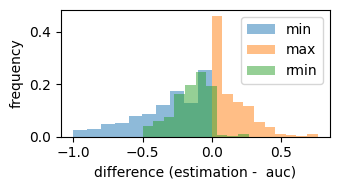

In [351]:
plt.figure(figsize=(3.5, 2))
plt.hist(data['auc_min'] - data['auc'], weights=np.repeat(1.0/len(data), len(data)), alpha=0.5, label='min')
plt.hist(data['auc_max'] - data['auc'], weights=np.repeat(1.0/len(data), len(data)), alpha=0.5, label='max')
plt.hist((data['auc_rmin'] - data['auc']).dropna(), weights=np.repeat(1.0/len(data['auc_rmin'].dropna()), len(data['auc_rmin'].dropna())), alpha=0.5, label='rmin')
plt.xlabel(f'difference (estimation - {clabel} auc)')
plt.ylabel('frequency')
plt.legend()
plt.tight_layout()
plt.savefig(f'figures-intervals/{label}-auc-diffs-hist.pdf')

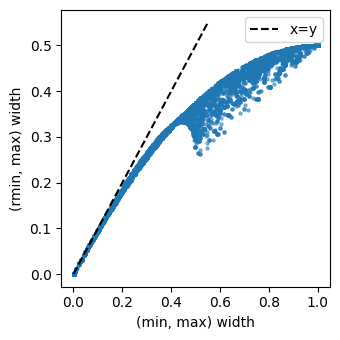

In [352]:
valx = (data['auc_max'] - data['auc_min']).max()*1.1
valy = (data['auc_max'] - data['auc_rmin']).max()*1.1

plt.figure(figsize=(3.5, 3.5))
plt.scatter(data['auc_max'] - data['auc_min'], 
            data['auc_max'] - data['auc_rmin'], 
            alpha=0.5, 
            s=5,
            #label='(min, max) vs. (rmin, max)'
            )
plt.plot([0, min(valx, valy)], [0, min(valx, valy)], label='x=y', c='black', linestyle='--')
plt.xlabel(r'(min, max) width')
plt.ylabel(r'(rmin, max) width')
plt.legend()
plt.tight_layout()
plt.savefig(f'figures-intervals/{label}-auc-interval-scatter.pdf')

In [353]:
results.append({'target': ['auc', 'auc'],
                'source': ['arbitrary fpr, tpr', 'arbitrary fpr, tpr'],
                'estimation': ['(min, max)', '(rmin, max)'],
                'avg. lower': [np.mean(data['auc_min'] - data['auc']),
                               np.mean(data['auc_rmin'] - data['auc'])],
                'avg. upper': [np.mean(data['auc_max'] - data['auc']),
                              np.mean(data['auc_max'] - data['auc'])]})

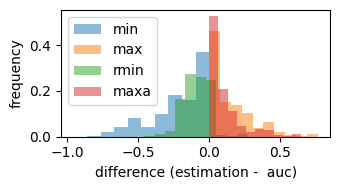

In [354]:
plt.figure(figsize=(3.5, 2))
plt.hist(data['auc_min_best'] - data['auc'], weights=np.repeat(1.0/len(data), len(data)), alpha=0.5, label='min')
plt.hist(data['auc_max_best'] - data['auc'], weights=np.repeat(1.0/len(data), len(data)), alpha=0.5, label='max')
plt.hist((data['auc_rmin_best'] - data['auc']).dropna(), weights=np.repeat(1.0/len(data['auc_rmin_best'].dropna()), len(data['auc_rmin_best'].dropna())), alpha=0.5, label='rmin')
plt.hist((data['auc_maxa_best'] - data['auc']).dropna(), weights=np.repeat(1.0/len(data['auc_maxa_best'].dropna()), len(data['auc_maxa_best'].dropna())), alpha=0.5, label='maxa')
plt.xlabel(f'difference (estimation - {clabel} auc)')
plt.ylabel('frequency')
plt.legend()
plt.tight_layout()
plt.savefig(f'figures-intervals/{label}-auc-macc-diffs-hist.pdf')

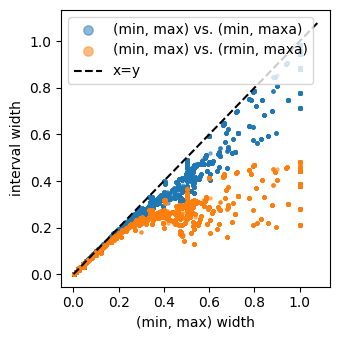

In [355]:
valx = (data['auc_max_best'] - data['auc_min_best']).max()*1.1
valy = (data['auc_maxa_best'] - data['auc_min_best']).max()*1.1

plt.figure(figsize=(3.5, 3.5))
plt.scatter(data['auc_max_best'] - data['auc_min_best'], 
            data['auc_maxa_best'] - data['auc_min_best'], 
            alpha=0.5, 
            s=5,
            label='(min, max) vs. (min, maxa)'
            )
plt.scatter(data['auc_max_best'] - data['auc_min_best'], 
            data['auc_maxa_best'] - data['auc_rmin_best'], 
            alpha=0.5, 
            s=5,
            label='(min, max) vs. (rmin, maxa)'
            )
plt.plot([0, min(valx, valy)], [0, min(valx, valy)], label='x=y', c='black', linestyle='--')
plt.xlabel(r'(min, max) width')
plt.ylabel(r'interval width')
plt.legend(markerscale=3)
plt.tight_layout()
plt.savefig(f'figures-intervals/{label}-auc-macc-interval-scatter.pdf')

In [356]:
results.append({'target': ['auc', 'auc', 'auc', 'auc'],
                'source': ['fpr, tpr at max. acc.', 'fpr, tpr at max acc.', 'fpr, tpr at max acc.', 'fpr, tpr at max acc.'],
                'estimation': ['(min, max)', 
                               '(rmin, max)',
                               '(min, maxa)',
                               '(rmin, maxa)'],
                'avg. lower': [np.mean(data['auc_min_best'] - data['auc']),
                               np.mean(data['auc_rmin_best'] - data['auc']),
                               np.mean(data['auc_min_best'] - data['auc']),
                               np.mean(data['auc_rmin_best'] - data['auc'])],
                'avg. upper': [np.mean(data['auc_max_best'] - data['auc']),
                              np.mean(data['auc_maxa_best'] - data['auc']),
                              np.mean(data['auc_max_best'] - data['auc']),
                              np.mean(data['auc_maxa_best'] - data['auc'])]})

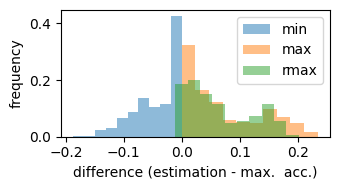

In [357]:
plt.figure(figsize=(3.5, 2))
plt.hist(data['max_acc_min'] - data['best_acc'], weights=np.repeat(1.0/len(data), len(data)), alpha=0.5, label='min')
plt.hist(data['max_acc_max'] - data['best_acc'], weights=np.repeat(1.0/len(data), len(data)), alpha=0.5, label='max')
plt.hist((data['max_acc_rmax'] - data['best_acc']).dropna(), weights=np.repeat(1.0/len(data['max_acc_rmax'].dropna()), len(data['max_acc_rmax'].dropna())), alpha=0.5, label='rmax')
plt.xlabel(f'difference (estimation - max. {clabel} acc.)')
plt.ylabel('frequency')
plt.legend()
plt.tight_layout()
plt.savefig(f'figures-intervals/{label}-max-acc-diffs-hist.pdf')

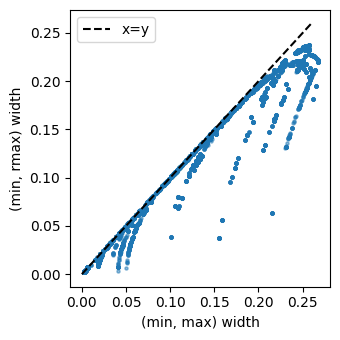

In [358]:
valx = (data['max_acc_max'] - data['max_acc_min']).max()*1.1
valy = (data['max_acc_rmax'] - data['max_acc_min']).max()*1.1
plt.figure(figsize=(3.5, 3.5))
plt.scatter(data['max_acc_max'] - data['max_acc_min'], 
            data['max_acc_rmax'] - data['max_acc_min'], 
            alpha=0.5, 
            s=5,
            #label='(min, max) vs. (min, rmax)'
            )
plt.plot([0, min(valx, valy)], [0, min(valx, valy)], label='x=y', c='black', linestyle='--')
plt.xlabel(r'(min, max) width')
plt.ylabel(r'(min, rmax) width')
plt.legend()
plt.tight_layout()
plt.savefig(f'figures-intervals/{label}-max-acc-interval-scatter.pdf')

In [359]:
results.append({'target': ['max. acc', 'max acc'],
                'source': ['auc', 'auc'],
                'estimation': ['(min, max)', '(min, rmax)'],
                'avg. lower': [np.mean(data['max_acc_min'] - data['best_acc']),
                               np.mean(data['max_acc_min'] - data['best_acc'])],
                'avg. upper': [np.mean(data['max_acc_max'] - data['best_acc']),
                              np.mean(data['max_acc_rmax'] - data['best_acc'])]})

In [360]:
results = pd.concat([pd.DataFrame(results[0]), pd.DataFrame(results[1]), pd.DataFrame(results[2])])

In [361]:
results.to_csv(f'results-intervals-{label}.csv', index=False)